In [2]:
pip install numpy matplotlib cvxpy

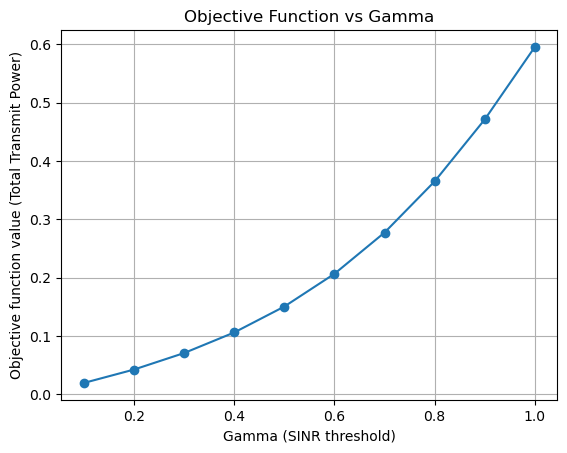

[[0.0962898 +0.j         0.00035072+0.08046452j 0.0559219 +0.10403103j]
 [0.00035072-0.08046452j 0.06741133+0.j         0.08722776-0.04640038j]
 [0.0559219 -0.10403103j 0.08722776+0.04640038j 0.14512283+0.j        ]]
[[ 0.03389137+0.j          0.01698444-0.08473341j  0.0038647 +0.03215934j]
 [ 0.01698444+0.08473341j  0.22110973+0.j         -0.07869852+0.02585506j]
 [ 0.0038647 -0.03215934j -0.07869852-0.02585506j  0.03114814+0.j        ]]
[[ 1.00002949e-04+0.00000000e+00j  4.37573062e-10-2.55078252e-09j
  -3.41473759e-09+1.26514091e-09j]
 [ 4.37573062e-10+2.55078252e-09j  9.99978455e-05+0.00000000e+00j
   6.95010084e-10-2.25792669e-10j]
 [-3.41473760e-09-1.26514093e-09j  6.95010074e-10+2.25792668e-10j
   9.99956459e-05+0.00000000e+00j]]


In [4]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Problem parameters
Ki = 2  # Number of users(ID)
Ke = 1  # Number of users(EH+ID)
Z = 3   # Number of groups
Zi = 2  # Number of groups for ID
Ze = 1  # Number of groups for EH+ID
UserGroup = [0, 1, 2]
m = 3   # Size of the matrices (e.g., number of antennas)

# Randomly generate channel vectors, SINR thresholds, and energy demands
np.random.seed(1)
gi_vectors = [np.random.randn(m, 1) + 1j * np.random.randn(m, 1) for _ in range(Ki)]  # Ki mx1 complex vectors
ge_vectors = [np.random.randn(m, 1) + 1j * np.random.randn(m, 1) for _ in range(Ke)]  # Ke mx1 complex vectors

# Form the channel matrices
Gi = [gi @ gi.conj().T for gi in gi_vectors]
Ge = [ge @ ge.conj().T for ge in ge_vectors]
xi = 1e-6
sigma_Ri = np.random.rand(Ki)
sigma_Rj = np.random.rand(Ke)
sigma_D = np.random.rand(Ki)
zeta = np.random.rand(Ke)

a = 1500
b = 0.0022
phi = 1/(1 + np.exp(a*b) )
e = 1e-3

# Define a range of gamma values
gamma_values = np.linspace(0.1, 1.0, 10)  # 10 values between 0.1 and 1.0
objective_values = []  # To store the objective function values

# Loop through each gamma value
for gamma_value in gamma_values:
    # Define the optimization variables
    W = [cp.Variable((m, m), complex=True) for _ in range(Z)]
    
    # Objective function: minimize the total transmit power
    objective = cp.Minimize(cp.real(sum(cp.trace(W_k) for W_k in W)))
    constraints = []
    
    # SINR constraints (C1)
    for i in range(Ki):
        grp = UserGroup[i]
        interference = 0
        for j in range(Z):
            if grp != j:
                interference += cp.real(cp.trace(Gi[i] @ W[j]))
        constraints.append(cp.real(cp.trace(Gi[i] @ W[grp])) - gamma_value * interference >= gamma_value * (sigma_Ri[i]**2 + sigma_D[i]**2))
    
    # Energy harvesting constraints (C2)
    for j in range(Ke):
        harvested_energy = sum(cp.real(cp.trace(Ge[j] @ W_k)) for W_k in W)
        log_term = np.log(((1-phi)*(e-xi)) / (1-phi)*e +(phi*xi))
        c = sigma_Rj[j]**2 + b - (log_term / a)
        xi_new = zeta[j] * c
        constraints.append(harvested_energy >= xi_new / zeta[j] - sigma_Rj[j]**2)

    epsilon = 1e-4
    
    # PSD constraint (C3)
    for W_k in W:
        constraints.append(W_k >> 0)
    
    for W_k in W:
        # Enforce that the smallest eigenvalue is at least epsilon
        constraints.append(cp.lambda_min(W_k) >= epsilon)
        
    # Define the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    # Store the objective function value if the problem is solved successfully
    if problem.status == cp.OPTIMAL:
        objective_values.append(problem.value)
    else:
        objective_values.append(np.nan)  # If not solvable, append NaN

# Plot the objective function values against gamma values
plt.plot(gamma_values, objective_values, marker='o')
plt.xlabel('Gamma (SINR threshold)')
plt.ylabel('Objective function value (Total Transmit Power)')
plt.title('Objective Function vs Gamma')
plt.grid(True)
plt.show()

for i in range(Z):
    print(W[i].value)